In [1]:
from xgboost import XGBRegressor
import gc
import json
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm

from numerapi import NumerAPI
from utils import (
    save_model,
    load_model,
    neutralize,
    validation_metrics,
    ERA_COL,
    DATA_TYPE_COL,
    TARGET_COL,
    EXAMPLE_PREDS_COL,
)

In [2]:
# download all the things

napi = NumerAPI()

current_round = napi.get_current_round()

# Tournament data changes every week so we specify the round in their name. Training
# and validation data only change periodically, so no need to download them every time.
print("Downloading dataset files...")
dataset_name = "v4.1"
feature_set_name = "medium"

In [3]:
Path(f"./{dataset_name}").mkdir(parents=False, exist_ok=True)

# we'll use the int8 in this example in order to save RAM.
# if you remove the int8 suffix for each of these files, you'll get features between 0 and 1 as floats.
# int_8 files are much smaller...
# but are harder to work with because some packages don't like ints and the way NAs are encoded.

# napi.download_dataset(f"{dataset_name}/train.parquet")
# napi.download_dataset(f"{dataset_name}/validation.parquet")
# napi.download_dataset(f"{dataset_name}/live.parquet", f"{dataset_name}/live_{current_round}.parquet")

napi.download_dataset(f"{dataset_name}/train_int8.parquet")
napi.download_dataset(f"{dataset_name}/validation_int8.parquet")
napi.download_dataset(
    f"{dataset_name}/live_int8.parquet",
    f"{dataset_name}/live_int8_{current_round}.parquet",
)

napi.download_dataset(f"{dataset_name}/validation_example_preds.parquet")
napi.download_dataset(f"{dataset_name}/features.json")

2023-05-03 07:54:18,581 INFO numerapi.utils: target file already exists
2023-05-03 07:54:18,582 INFO numerapi.utils: starting download
v4.1/train_int8.parquet: 2.90GB [00:47, 60.4MB/s]                                                                                                                                                                              
2023-05-03 07:55:07,034 INFO numerapi.utils: target file already exists
2023-05-03 07:55:07,035 INFO numerapi.utils: starting download
v4.1/validation_int8.parquet: 3.09GB [00:50, 61.1MB/s]                                                                                                                                                                         
2023-05-03 07:55:57,966 INFO numerapi.utils: starting download
v4.1/live_int8_476.parquet: 4.48MB [00:00, 19.1MB/s]                                                                                                                                                                       

In [4]:
print("Reading minimal training data")
# read the feature metadata and get a feature set (or all the features)


with open(f"{dataset_name}/features.json", "r") as f:
    feature_metadata = json.load(f)

# features = list(feature_metadata["feature_stats"].keys()) # get all the features
# features = feature_metadata["feature_sets"]["small"] # get the small feature set
features = feature_metadata["feature_sets"][
    feature_set_name
]  # get the medium feature set
target_cols = feature_metadata["targets"]
# read in just those features along with era and target columns
read_columns = features + target_cols + [ERA_COL, DATA_TYPE_COL]

# note: sometimes when trying to read the downloaded data you get an error about invalid magic parquet bytes...
# if so, delete the file and rerun the napi.download_dataset to fix the corrupted file
training_data = pd.read_parquet(
    f"{dataset_name}/train_int8.parquet", columns=read_columns
)
validation_data = pd.read_parquet(
    f"{dataset_name}/validation_int8.parquet", columns=read_columns
)
validation_data = validation_data[validation_data.data_type=='validation']
live_data = pd.read_parquet(f"{dataset_name}/live_int8_{current_round}.parquet", columns=read_columns)

Reading minimal training data


In [5]:
# get all the data to possibly use for training
all_data = pd.concat([training_data, validation_data])

# save indices for easier data selection later
training_index = training_data.index
validation_index = validation_data.index
all_index = all_data.index

# delete training and validation data to save space
del training_data
del validation_data
gc.collect()  # clear up memory

# Int8 datatype has pd.NA which don't play nice with models.  We simply fill NA with median values here
print("cleaning up NAs")
all_data[features] = all_data[features].fillna(all_data[features].median(skipna=True))
all_data[features] = all_data[features].astype("int8")  # make sure change to float32 if using the non int8 data!
live_data[features] = live_data[features].fillna(
    all_data[features].median(skipna=True)
)  # since live data is only one era, we need to use the median for all eras
live_data[features] = live_data[features].astype("int8")  # make sure change to float32 if using the non int8 data!
# Alternatively could convert nan columns to be floats and replace pd.NA with np.nan

cleaning up NAs


Discretizing and 1-hot encoding features can make linear regression perform like a decision tree. KBinsDiscretizer discritizes each features separately. Fitting a decision tree results in new discritezed features, which are composed of learned non-linear interactions of the input features, as well as weights on those features, the leaf weights. A decision tree can be decomposed  as a 1-hot feature encoder and the linear weights on the 1-hot encoded features. This decomposition is similar to the relationship between the non-linear intermediate layers of a deep neural network and the linear output weights. A similar idea can be found in this paper:
https://scontent.fmaa12-3.fna.fbcdn.net/v/t39.8562-6/240842589_204052295113548_74168590424110542_n.pdf?_nc_cat=109&ccb=1-7&_nc_sid=ad8a9d&_nc_ohc=4N77V0biifQAX_OmaRN&_nc_ht=scontent.fmaa12-3.fna&oh=00_AfCHgYK5WowapvGPM64kU6tm5fDCAzPk_v_lTvdAkndQSw&oe=641F3A4A


https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization.html#sphx-glr-auto-examples-preprocessing-plot-discretization-py

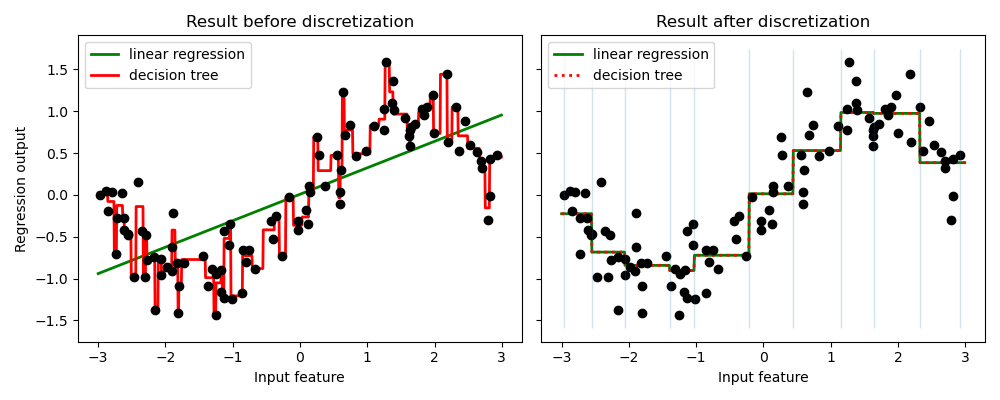

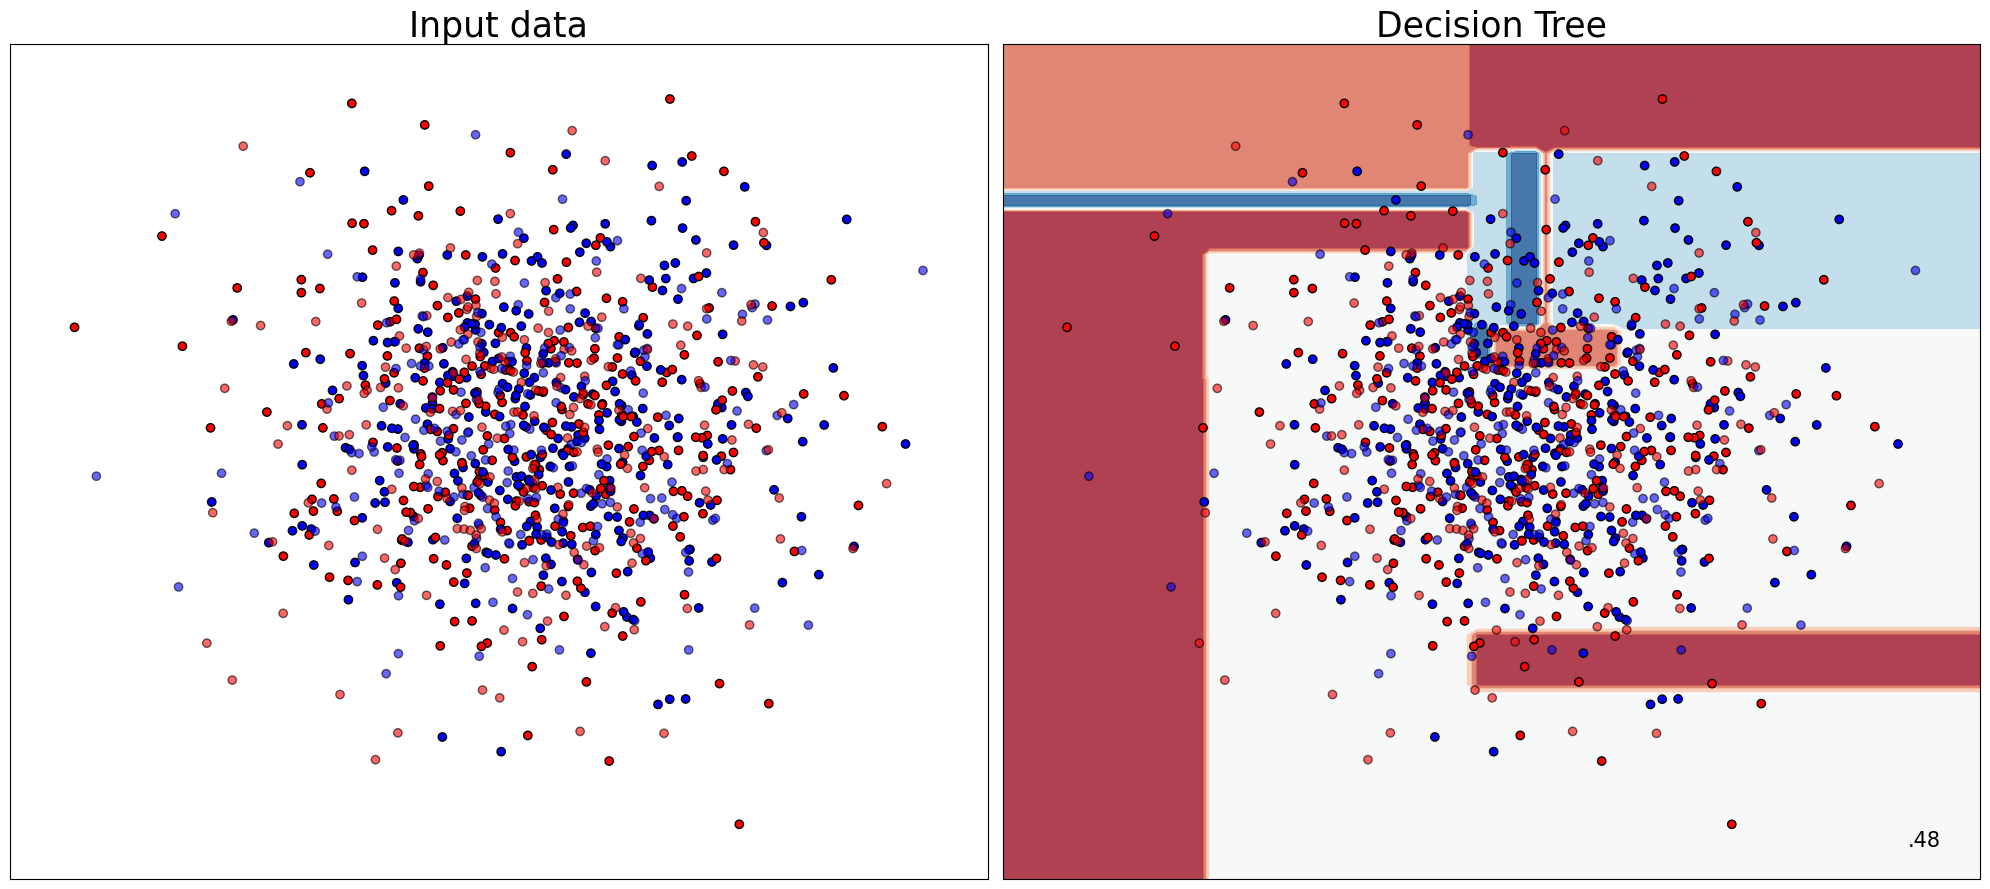

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay

names = [
    "Decision Tree",
]

classifiers = [
    DecisionTreeClassifier(max_depth=5),
]

x1 = np.random.randn(1000, 2)
y1 = np.zeros((1000,1))
y1[500:] = 1

datasets = [
    (x1,y1)
]

figure = plt.figure(figsize=(20, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data", fontsize=25)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name, fontsize=25)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

In [7]:
def string_parser(s):
    if len(re.findall(r":leaf=", s)) == 0:
        out  = re.findall(r"[\w.-]+", s)
        tabs = re.findall(r"[\t]+", s)
        if (out[4] == out[8]):
            missing_value_handling = (" or np.isnan(x['" + out[1] + "']) ")
        else:
            missing_value_handling = ""
            
        if len(tabs) > 0:
            return (re.findall(r"[\t]+", s)[0].replace('\t', '    ') + 
                    '        if state == ' + out[0] + ':\n' +
                    re.findall(r"[\t]+", s)[0].replace('\t', '    ') +
                    '            state = (' + out[4] +  
                    ' if ' +  "x['" + out[1] +"']<" + out[2] + missing_value_handling + 
                    ' else ' + out[6] + ')\n' )
        
        else:
            return ('        if state == ' + out[0] + ':\n' +
                    '            state = (' + out[4] +  
                    ' if ' +  "x['" + out[1] +"']<" + out[2] + missing_value_handling +
                    ' else ' + out[6] + ')\n' )
    else:
        out = re.findall(r"[\d.-]+[\d.e-]+", s)
        return (re.findall(r"[\t]+", s)[0].replace('\t', '    ') + 
                '        if state == ' + out[0] + ':\n    ' +
                re.findall(r"[\t]+", s)[0].replace('\t', '    ') + 
                '        return ' + out[1] + '\n')


def leaf_parser(s):
    if len(re.findall(r":leaf=", s)) > 0:
        out = re.findall(r"[\d.-]+[\d.e-]+", s)
        return out[1]
      
def tree_parser(tree, i):
    if i == 0:
        return ('    if num_booster == 0:\n        state = 0\n'
             + "".join([string_parser(tree.split('\n')[i]) 
                        for i in range(len(tree.split('\n'))-1)]))
    else:
        return ('    elif num_booster == '+str(i)+':\n        state = 0\n'
             + "".join([string_parser(tree.split('\n')[i]) 
                        for i in range(len(tree.split('\n'))-1)])) 

def tree_parser2(tree, i):
    leaves=[]
    for i in range(len(tree.split('\n'))-1):
        leaf = leaf_parser(tree.split('\n')[i])
        if leaf is not None:
            leaves.append(leaf)
    return leaves


def tree_parser3(tree):
    treesplit = tree.split('\n')
    leaves=[]
    for i in range(len(treesplit)-1):    
        for branch in treesplit:
            if f'\t{i}:leaf' in branch:
                leaves.append(branch.split('=')[-1])
                break
    return leaves
    
def model_to_py(base_score, model, out_file):
    trees = model.get_dump()
    result = ["import numpy as np\n\n" 
             +"def xgb_tree(x, num_booster):\n"]
    
    for i in range(len(trees)):
        result.append(tree_parser(trees[i], i))
    
    with open(out_file, 'a') as the_file:
        the_file.write("".join(result) + "\ndef xgb_predict(x):\n    predict = " 
                       + str(base_score) + "\n"
                       + "# initialize prediction with base score\n" 
                       + "    for i in range(" 
                       + str(len(trees))  
                       + "):\n        predict = predict + xgb_tree(x, i)"
                       + "\n    return predict")


def get_all_leaves(model):
    trees = model.get_dump()
    result = []
    
    for i in range(len(trees)):
        result.append(tree_parser3(trees[i]))
    
    return result


In [8]:
model = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, n_jobs=-1, colsample_bytree=0.1)
model.fit(all_data.loc[training_index,features], all_data.loc[training_index,"target_nomi_v4_20"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.1, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [9]:
from sklearn.preprocessing import OneHotEncoder

# get the index of the leaf output from each tree the the boosted ensemble
x_new_train = model.apply(all_data.loc[training_index,features])

In [10]:
x_new_train.shape

(2420521, 100)

In [11]:
x_new_train[0]

array([45., 37., 62., 48., 45., 52., 32., 40., 36., 53., 49., 52., 61.,
       62., 57., 50., 51., 42., 57., 47., 44., 55., 52., 39., 44., 49.,
       31., 42., 42., 53., 52., 35., 43., 53., 44., 62., 49., 53., 36.,
       43., 59., 44., 41., 47., 59., 32., 33., 33., 38., 48., 60., 47.,
       58., 31., 46., 46., 39., 55., 41., 49., 50., 51., 31., 31., 61.,
       40., 34., 43., 53., 53., 61., 61., 51., 60., 49., 49., 38., 55.,
       57., 36., 55., 51., 45., 40., 40., 61., 31., 55., 42., 60., 46.,
       48., 44., 38., 40., 53., 46., 56., 45., 61.], dtype=float32)

In [12]:
# Turn leaf indicies into a OneHotEncoding
grd_enc = OneHotEncoder(dtype='float32')
grd_enc.fit(x_new_train)

OneHotEncoder(dtype='float32')

In [13]:
x_new_train = grd_enc.transform(x_new_train)

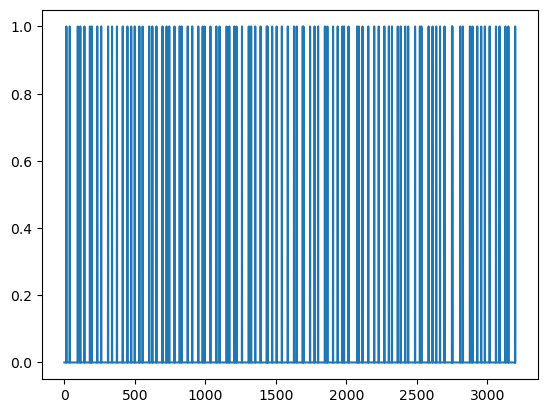

In [14]:
plt.plot(x_new_train[0].todense().T)

In [15]:
x_new_val = model.apply(all_data.loc[validation_index,features])

In [16]:
x_new_val = grd_enc.transform(x_new_val)

In [17]:
leaves = get_all_leaves(model.get_booster())
leaves = np.float64(np.concatenate(leaves))[None,:]

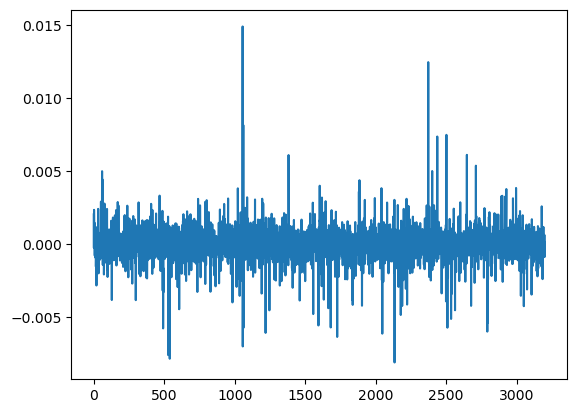

In [18]:
plt.plot(leaves.T)

In [19]:
pred = 0
for i in range(0, x_new_train.shape[1], 100):
    pred += np.dot(x_new_train[:,i:i+100].todense(), leaves[:,i:i+100].T)

In [20]:
xgbpred = model.predict(all_data.loc[training_index,features])

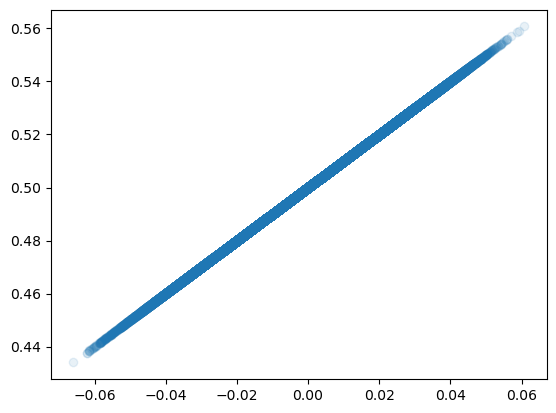

In [21]:
plt.scatter(np.array(pred[:,0]), np.array(xgbpred), alpha=.1)

In [35]:
nb = leaves - (np.sign(leaves))*.001
nb[np.sign(nb)!=np.sign(leaves)]=0

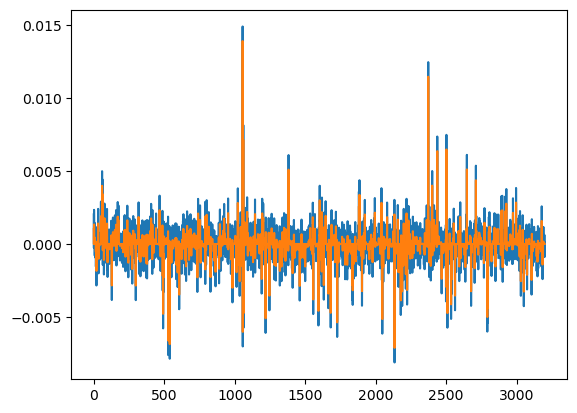

In [36]:
plt.plot(leaves.T)
plt.plot(nb.T)

In [37]:
xgbpred_val = model.predict(all_data.loc[validation_index,features])

In [38]:
all_data.loc[validation_index, 'xgbpred'] = xgbpred_val

In [39]:
pred_val = 0
for i in range(0, x_new_val.shape[1], 100):
    pred_val += np.dot(x_new_val[:,i:i+100].todense(), nb[:,i:i+100].T)
pred_val += 0.5

In [40]:
all_data.loc[validation_index, 'pred'] = np.array(pred_val)[:,0]

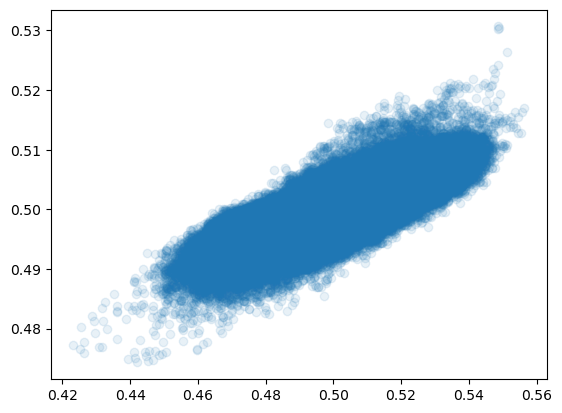

In [41]:
plt.scatter(xgbpred_val, np.array(pred_val[:,0]), alpha=.1)

In [42]:
def fast_score_by_date(df, columns, target, tb=None, era_col="era"):
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        df_era = df[df[era_col] == u]
        era_pred = np.float64(df_era[columns].values.T)
        era_target = np.float64(df_era[target].values.T)
        if tb is None:
            ccs = np.corrcoef(era_target, era_pred)[0, 1:]
        else:
            tbidx = np.argsort(era_pred, axis=1)
            tbidx = np.concatenate([tbidx[:, :tb], tbidx[:, -tb:]], axis=1)
            ccs = [np.corrcoef(era_target[tmpidx], tmppred[tmpidx])[0, 1] for tmpidx, tmppred in zip(tbidx, era_pred)]
            ccs = np.array(ccs)

        computed.append(ccs)

    return pd.DataFrame(np.array(computed), columns=columns, index=df[era_col].unique())

In [43]:
pred_corrs = fast_score_by_date(all_data.loc[validation_index], ['pred', 'xgbpred'], 'target')[4:]

In [44]:
pred_corrs.mean()/pred_corrs.std()

pred       0.830887
xgbpred    0.790317
dtype: float64

In [45]:
pred_corrs.mean()

pred       0.019468
xgbpred    0.027716
dtype: float64

In [46]:
pred_corrs.std()

pred       0.02343
xgbpred    0.03507
dtype: float64

In [47]:
pred_corrs.min()

pred      -0.056740
xgbpred   -0.088482
dtype: float64

In [48]:
pred_corrs = fast_score_by_date(all_data.loc[validation_index], ['pred', 'xgbpred'], 'target', tb=100)[4:]

In [49]:
pred_corrs.mean()/pred_corrs.std()

pred       0.559926
xgbpred    0.701859
dtype: float64

In [50]:
pred_corrs.mean()

pred       0.044545
xgbpred    0.073255
dtype: float64

In [51]:
pred_corrs.std()

pred       0.079554
xgbpred    0.104373
dtype: float64

In [52]:
pred_corrs.min()

pred      -0.190934
xgbpred   -0.262505
dtype: float64

In [53]:
nb = leaves - ((leaves**3)*10000)
nb[np.sign(nb)!=np.sign(leaves)]=0

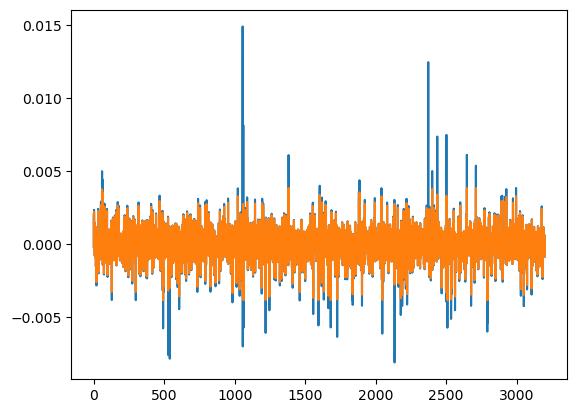

In [54]:
plt.plot(leaves.T)
plt.plot(nb.T)

In [55]:
pred_val = 0
for i in range(0, x_new_val.shape[1], 100):
    pred_val += np.dot(x_new_val[:,i:i+100].todense(), nb[:,i:i+100].T)
pred_val += 0.5

all_data.loc[validation_index, 'pred'] = np.array(pred_val)[:,0]

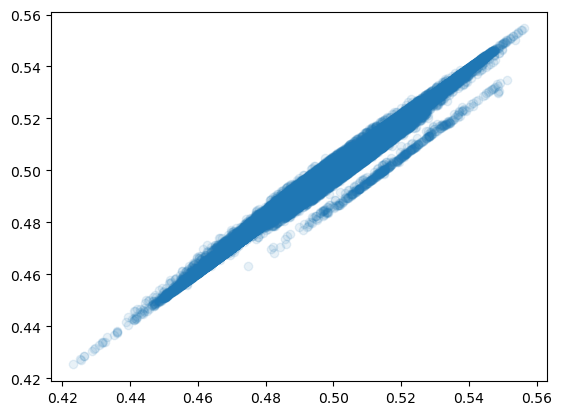

In [56]:
plt.scatter(xgbpred_val, np.array(pred_val[:,0]), alpha=.1)

In [57]:
pred_corrs = fast_score_by_date(all_data.loc[validation_index], ['pred', 'xgbpred'], 'target', tb=100)[4:]

In [58]:
pred_corrs.mean()/pred_corrs.std()

pred       0.710374
xgbpred    0.701859
dtype: float64

In [59]:
pred_corrs.mean()

pred       0.074517
xgbpred    0.073255
dtype: float64

In [60]:
pred_corrs.std()

pred       0.104899
xgbpred    0.104373
dtype: float64

In [61]:
pred_corrs.min()

pred      -0.254394
xgbpred   -0.262505
dtype: float64

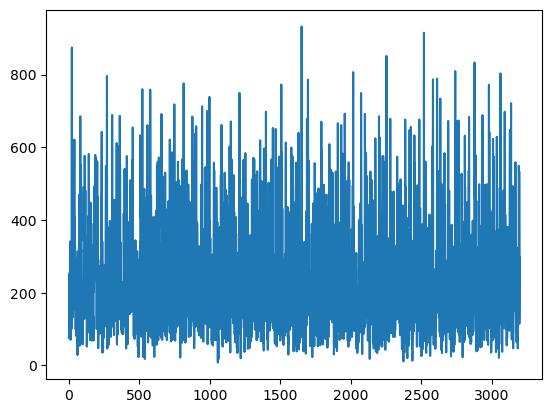

In [62]:
plt.plot(np.sqrt(x_new_train.sum(axis=0).T))

In [22]:
nb = leaves - ((leaves**3)*10000)
nb[np.sign(nb)!=np.sign(leaves)]=0

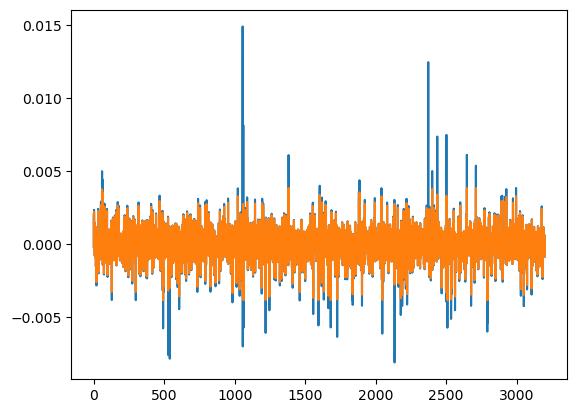

In [23]:
plt.plot(leaves.T)
plt.plot(nb.T)

In [96]:
# shrinkage = np.array(1/np.sqrt(x_new_train.sum(axis=0).T))
shrinkage = np.array(1/x_new_train.sum(axis=0).T)

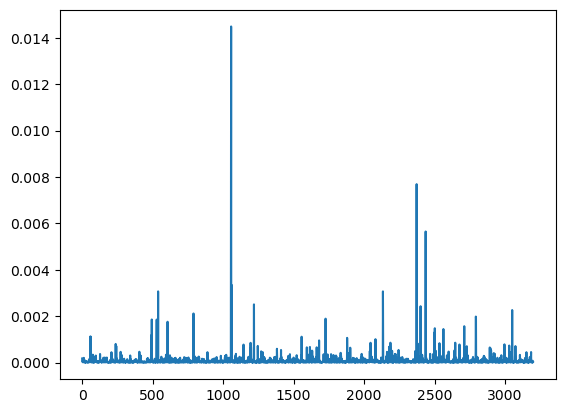

In [97]:
plt.plot(shrinkage)

In [65]:
nb = leaves - (np.sign(leaves)* shrinkage.T)*2
# nb = leaves - ((leaves**3)* shrinkage.T *100000)
# nb = leaves - (np.sign(leaves))*.0015
nb[np.sign(nb)!=np.sign(leaves)]=0

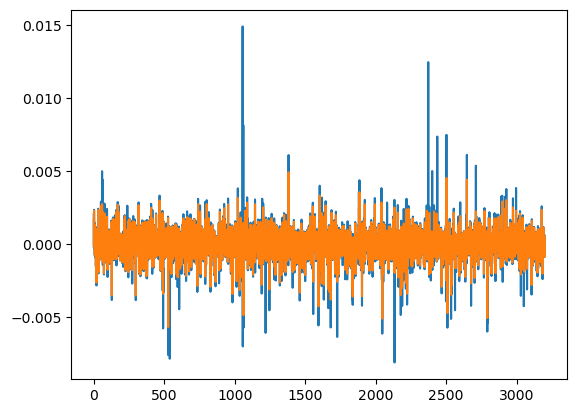

In [66]:
plt.plot(leaves.T)
plt.plot(nb.T)

In [67]:
pred_val = 0
for i in range(0, x_new_val.shape[1], 100):
    pred_val += np.dot(x_new_val[:,i:i+100].todense(), nb[:,i:i+100].T)
pred_val += 0.5

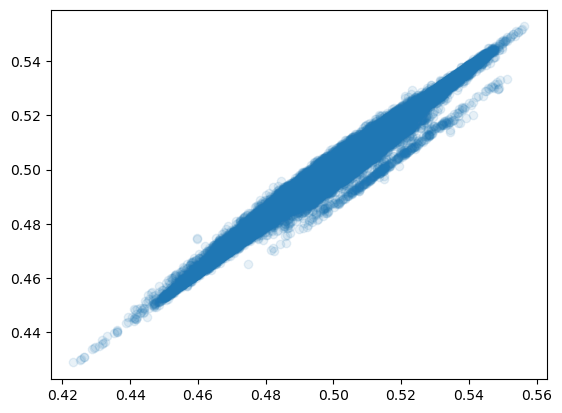

In [68]:
plt.scatter(xgbpred_val, np.array(pred_val[:,0]), alpha=.1)

In [69]:
all_data.loc[validation_index, 'pred'] = np.array(pred_val)[:,0]

In [70]:
pred_corrs = fast_score_by_date(all_data.loc[validation_index], ['pred', 'xgbpred'], 'target', tb=100)[4:]

In [71]:
pred_corrs.mean()/pred_corrs.std()

pred       0.716416
xgbpred    0.701859
dtype: float64

In [72]:
pred_corrs.mean()

pred       0.073982
xgbpred    0.073255
dtype: float64

In [73]:
pred_corrs.std()

pred       0.103267
xgbpred    0.104373
dtype: float64

In [74]:
pred_corrs.min()

pred      -0.247735
xgbpred   -0.262505
dtype: float64

In [75]:
erad = all_data.era

In [76]:
era_idxs = []
for era in all_data.loc[training_index,"era"].unique():
    print(era, end='\r')
    era_idxs.append(np.where(erad==era))

0574

In [77]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV

In [78]:
lr = Ridge(alpha=100)

In [79]:
coefs = []
for i, era_idx in enumerate(era_idxs):
    print(i, end='\r')
    data = np.array(x_new_train[era_idx].todense())
    target = all_data.iloc[era_idx]["target_nomi_v4_20"]
    lr.fit(data, target-.5)
    coefs.append(lr.coef_)

573

In [80]:
coefs = np.array(coefs)

In [81]:
coefs_n = coefs - coefs.mean(axis=1, keepdims=True)
coefs_n /= coefs_n.std(axis=1, keepdims=True)

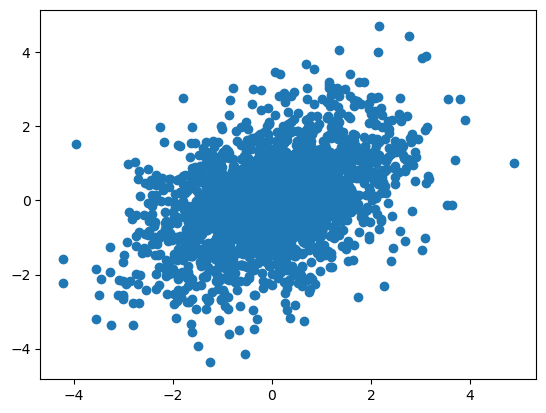

In [82]:
import matplotlib.pyplot as plt
plt.scatter(coefs_n[100], coefs_n[101])

/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


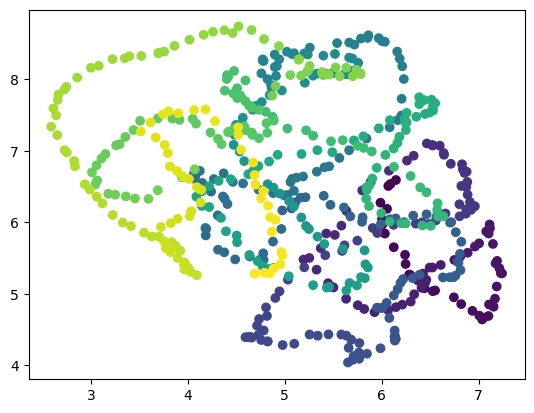

In [83]:
import umap

embedder = umap.UMAP(n_neighbors=15, n_components=3)

embedding= embedder.fit_transform(coefs_n)

colors = np.linspace(0,1, len(embedding))

# To plot a scatter graph, use scatter() function
plt.scatter(embedding[:,1], embedding[:,0], c=colors[:], cmap='viridis')



In [84]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float, axis=0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def taylor_series_extrapolator(data, steps = 1, av = 2):
    d1 = np.diff(data, axis=0)
    d1 = moving_average(d1, av)
    d2 = np.diff(d1, axis=0)
    d2 = moving_average(d2, av)
    d3 = np.diff(d2, axis=0)
    d3 = moving_average(d3, av)

    
    start = data[-1]
    extrapolation = []
    for step in range(1, steps+1):
        extrapolation.append(start + step*d1[-1] + ((step**2)/2)*d2[-1] + ((step**3)/6)*d3[-1])
    return np.vstack(extrapolation)

In [85]:
exts = taylor_series_extrapolator(embedding, 5, 5)

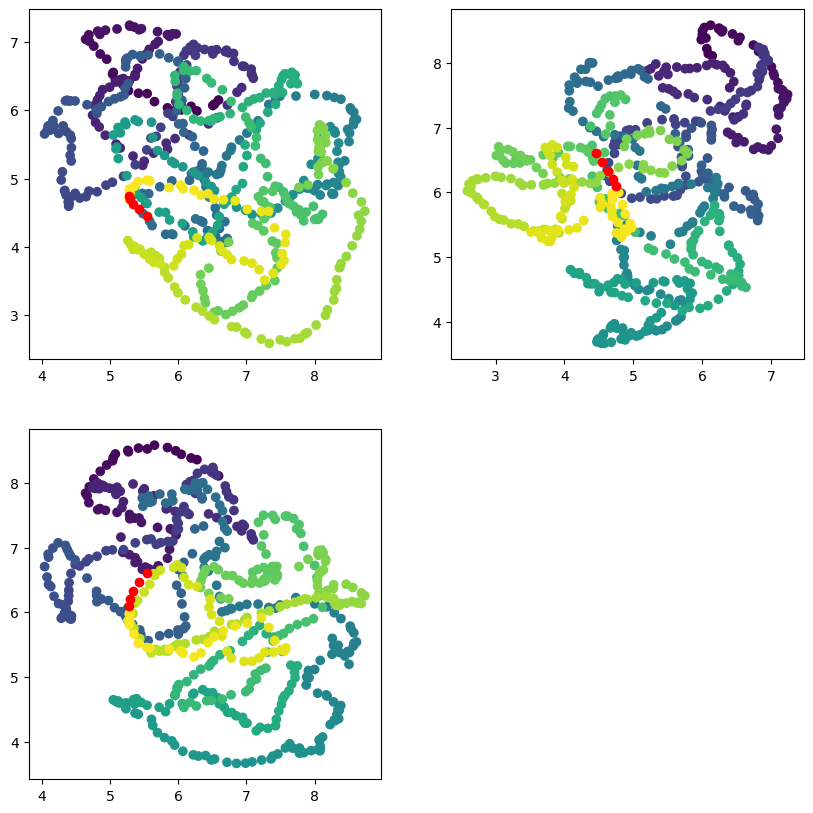

In [86]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(embedding[:,0], embedding[:,1], c=colors[:], cmap='viridis')
plt.scatter(exts[:,0], exts[:,1], color='red')
plt.subplot(2,2,2)
plt.scatter(embedding[:,1], embedding[:,2], c=colors[:], cmap='viridis')
plt.scatter(exts[:,1], exts[:,2], color='red')
plt.subplot(2,2,3)
plt.scatter(embedding[:,0], embedding[:,2], c=colors[:], cmap='viridis')
plt.scatter(exts[:,0], exts[:,2], color='red')

In [87]:
from sklearn.kernel_ridge import KernelRidge

In [88]:
krrs = []
dd = embedding[:,None] - embedding[None,]
# Use cubic RBF
K = np.linalg.norm(dd, axis=2)**3
for i in range(coefs_n.shape[1]):
    print(i, end = '\r')
    kr = KernelRidge(kernel="precomputed", alpha=0.01)

    kr.fit(K, coefs_n[:,i])
    krrs.append(kr)

/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/home/michael/miniforge3/envs/numerai-quant/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


In [89]:
# krrs = []
# for i in range(coefs_n.shape[1]):
#     print(i, end = '\r')
#     kr = KernelRidge(kernel="laplacian", gamma=.01, alpha=0.01)
#     kr.fit(embedding, coefs_n[:,i])
#     krrs.append(kr)

In [90]:
def invert_embedding(emb, krrs):
    pred = []
    for kr in krrs:
        pred.append(kr.predict(emb.reshape(1, -1)))
    pred = np.concatenate(pred)
    return pred

In [91]:
def K_matrix(embedding, pt):
    dd2 = embedding- pt
    return np.linalg.norm(dd2, axis=1)**3

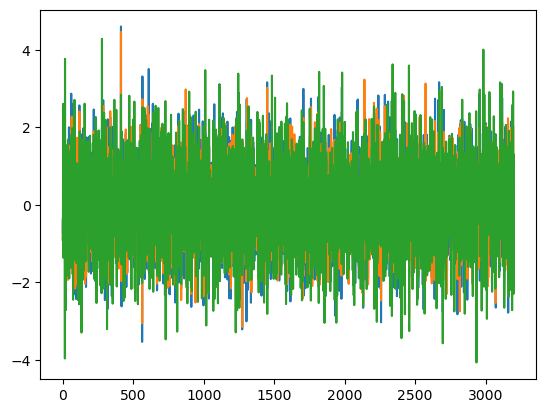

In [92]:
plt.plot(coefs_n[-1])
plt.plot(invert_embedding(K_matrix(embedding, embedding[-1]), krrs))
plt.plot(invert_embedding(K_matrix(embedding, exts[-1]), krrs))
# plt.plot(invert_embedding(embedding[-1], krrs))
# plt.plot(invert_embedding(exts[-1], krrs))

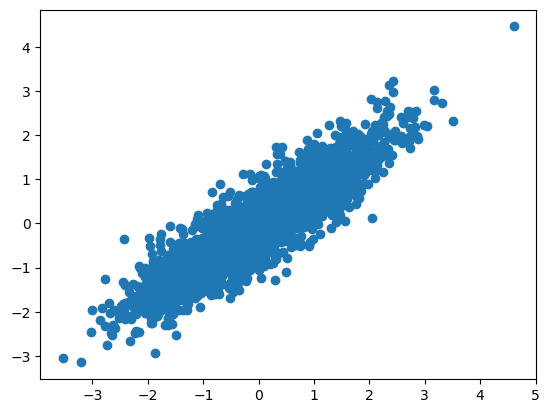

In [93]:
plt.scatter(coefs_n[-1], invert_embedding(K_matrix(embedding, embedding[-1]), krrs))

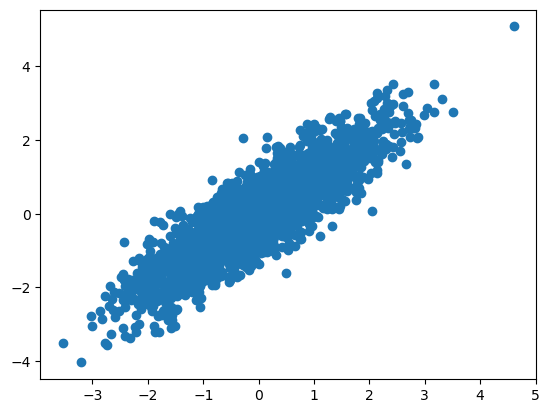

In [94]:
plt.scatter(coefs_n[-1], invert_embedding(K_matrix(embedding, exts[0]), krrs))
# plt.scatter(coefs_n[-1], invert_embedding(exts[-1], krrs))

In [95]:
plt.scatter(coefs_n[-1], invert_embedding(embedding[-1], krrs))

ValueError: X has 3 features, but KernelRidge is expecting 574 features as input.

In [ ]:
# plt.scatter(invert_embedding(K_matrix(embedding, embedding[-1]), krrs), invert_embedding(K_matrix(embedding, exts[-1]), krrs))
plt.scatter(invert_embedding(embedding[-1], krrs), invert_embedding(exts[-1], krrs))

In [ ]:
plt.plot(coefs_n[-1])
plt.plot(pp)

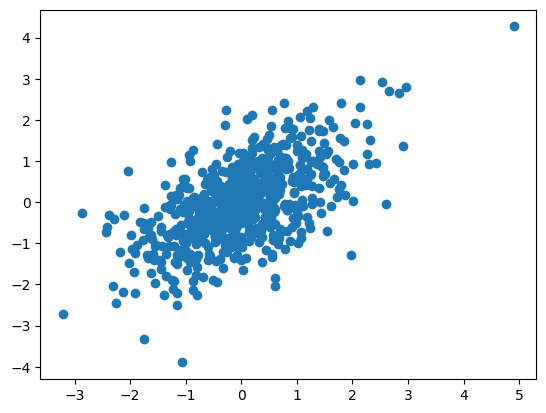

In [396]:
plt.scatter(invert_embedding(K_matrix(embedding, embedding[-1]), krrs), invert_embedding(K_matrix(embedding, embedding[-2]), krrs))

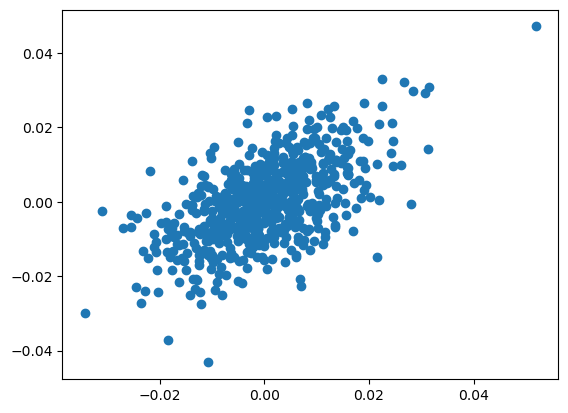

In [397]:
plt.scatter(coefs[-1], coefs[-2])

In [ ]:
plt.plot(embedder.inverse_transform(embedding[500].reshape(1, -1)).T)

In [98]:
np.corrcoef(coefs_n[11], embedder.inverse_transform(embedding[11].reshape(1, -1)))

array([[1.        , 0.05911678],
       [0.05911678, 1.        ]])

In [46]:
embedder.inverse_transform?

In [34]:
inv_transformed_points = embedder.inverse_transform(np.array([0,0]).reshape(1, -1))

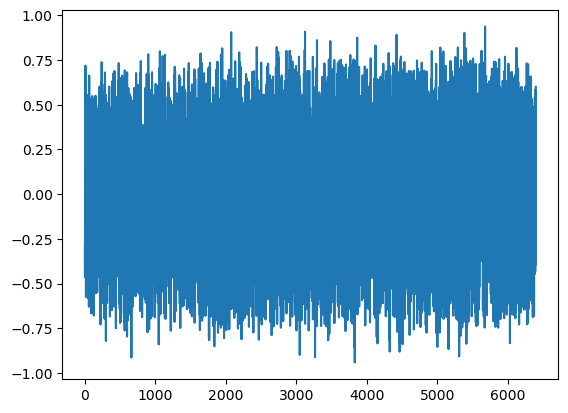

In [35]:
plt.plot(inv_transformed_points.T)

In [ ]:
# number of points in bin to determine sigificance of high value, shrink bins w/ small # more

In [23]:
import matplotlib.pyplot as plt